Code mẫu đơn giản cho từng bước — có thể chạy bằng NumPy (chạy từng block trong Python/Notebook)

Dưới đây là một bộ code ngắn, thực dụng, mỗi phần kèm ví dụ nhỏ. Chạy tuần tự để hiểu luồng: toán cơ bản → affine → activation → forward → cost → backward → update → batching → training đơn giản. Mình viết theo kiểu column-vector convention:

X: shape (n_x, m) (m mẫu),

Y: shape (n_y, m) (one-hot cho multiclass hoặc (1,m) cho binary),

W: (n_out, n_in), b: (n_out,1), Z: (n_out,m).


0. Imports chung


In [ ]:
import numpy as np
np.random.seed(1)


1. Toán nền: dot product, shapes (ví dụ nhanh)


In [ ]:
# Ví dụ trực quan
a = np.array([1, 2, 3])          # shape (3,)
b = np.array([4, 5, 6])
print("dot:", np.dot(a, b))     # 1*4 + 2*5 + 3*6 = 32

# Với ma trận
A = np.array([[1, 2], [3, 4]])    # (2,2)
x = np.array([[5], [6]])        # (2,1)
print("A.dot(x) =", A.dot(x))  # shape (2,1)


dot: 32
A.dot(x) = [[17]
 [39]]


2. Per-neuron / affine: Z = W X + b


In [ ]:
def affine_forward(W, X, b):
    # W: (n_out, n_in), X: (n_in, m), b: (n_out,1)
    Z = W.dot(X) + b  # broadcasting b across m columns
    cache = (W, X, b)
    return Z, cache


# ví dụ:
W = np.array([[2., -1.]])     # (1,2)
X = np.array([[1., 3., -1.], [2., 0., 4.]])  # (2,3)
b = np.array([[0.5]])         # (1,1)
Z, _ = affine_forward(W, X, b)
print("Z shape:", Z.shape)
print(Z)


Z shape: (1, 3)
[[ 0.5  6.5 -5.5]]


3. Activation functions (forward + cache)


In [ ]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z


def relu(Z):
    A = np.maximum(0, Z)
    return A, Z


def softmax(Z):
    # numerically stable softmax per column
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z_shift)
    A = expZ / np.sum(expZ, axis=0, keepdims=True)
    return A, Z


# quick test
Z_test = np.array([[-1., 2., 0.], [0.5, -0.1, 3.]])
print("softmax:", softmax(Z_test)[0])


softmax: [[0.18242552 0.89090318 0.04742587]
 [0.81757448 0.10909682 0.95257413]]


4. Forward propagation: linear -> activation (vectorized)


In [ ]:
def linear_activation_forward(W, X, b, activation):
    Z, linear_cache = affine_forward(W, X, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
    else:
        raise ValueError("Unknown activation")
    cache = (linear_cache, activation_cache)
    return A, cache


# single-layer example:
W = np.random.randn(2, 3)
X = np.random.randn(3, 4)  # 4 samples
b = np.zeros((2, 1))
A, cache = linear_activation_forward(W, X, b, activation="relu")
print("A shape:", A.shape)


A shape: (2, 4)


5. Compute cost (binary CE and multiclass CE)


In [ ]:
def compute_cost_binary(AL, Y):
    m = Y.shape[1]
    eps = 1e-8
    cost = -1/m * np.sum(Y * np.log(AL + eps) + (1-Y) * np.log(1-AL + eps))
    return np.squeeze(cost)


def compute_cost_multiclass(AL, Y):
    # AL: (n_y, m) softmax outputs; Y: one-hot (n_y, m)
    m = Y.shape[1]
    eps = 1e-8
    cost = -1/m * np.sum(Y * np.log(AL + eps))
    return np.squeeze(cost)


6. Backprop cơ bản cho 1 layer: linear_backward và activation backward


In [ ]:
def relu_backward(dA, cache):
    Z = cache
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ


def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ


def linear_backward(dZ, cache):
    W, X, b = cache
    m = X.shape[1]
    dW = (1/m) * dZ.dot(X.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T.dot(dZ)
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "softmax":
        # for softmax + CE, dZ = AL - Y normally (handled at top-level)
        dZ = dA
    else:
        raise ValueError("Unknown activation")
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db


Chú ý: với softmax + cross-entropy, thường dZ = AL - Y so bạn truyền dA = AL - Y vào linear_activation_backward với activation="softmax" để skip tính đạo hàm softmax.


7. L-layer forward / backward + parameter init


In [ ]:
def initialize_parameters_deep(layer_dims, init="he"):
    # layer_dims: list [n_x, n_h1, n_h2, ..., n_y]
    parameters = {}
    L = len(layer_dims) - 1
    for l in range(1, L+1):
        n_l = layer_dims[l]
        n_prev = layer_dims[l-1]
        if init == "he":
            parameters[f"W{l}"] = np.random.randn(
                n_l, n_prev) * np.sqrt(2. / n_prev)
        elif init == "xavier":
            parameters[f"W{l}"] = np.random.randn(
                n_l, n_prev) * np.sqrt(1. / n_prev)
        else:
            parameters[f"W{l}"] = np.random.randn(n_l, n_prev) * 0.01
        parameters[f"b{l}"] = np.zeros((n_l, 1))
    return parameters


def L_model_forward(X, parameters, hidden_activation="relu", output_activation="sigmoid"):
    caches = []
    A = X
    L = len([k for k in parameters.keys()]) // 2
    for l in range(1, L):
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A, cache = linear_activation_forward(
            W, A, b, activation=hidden_activation)
        caches.append(cache)
    # output layer
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    A, cache = linear_activation_forward(W, A, b, activation=output_activation)
    caches.append(cache)
    return A, caches


def L_model_backward(AL, Y, caches, output_activation="sigmoid", hidden_activation="relu"):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    # output layer dA -> dZ for softmax/sigmoid:
    if output_activation == "sigmoid":
        dAL = - (np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))
        dA_prev, dW, db = linear_activation_backward(
            dAL, caches[-1], activation="sigmoid")
    elif output_activation == "softmax":
        # when Y is one-hot, dZ = AL - Y
        dZL = AL - Y
        dA_prev, dW, db = linear_activation_backward(
            dZL, caches[-1], activation="softmax")
    else:
        raise ValueError("Unknown output activation")

    grads[f"dW{L}"] = dW
    grads[f"db{L}"] = db
    dA_prev_current = dA_prev

    for l in reversed(range(L-1)):
        cache = caches[l]
        dA_prev_current, dW, db = linear_activation_backward(
            dA_prev_current, cache, activation=hidden_activation)
        grads[f"dW{l+1}"] = dW
        grads[f"db{l+1}"] = db

    return grads


8. Update parameters (SGD)


In [ ]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L+1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    return parameters


9. Mini-batches (shuffling)


In [ ]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    mini_batches = []
    num_complete_minibatches = m // mini_batch_size
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    return mini_batches


10. Ví dụ training đơn giản (1 hidden layer, binary)


epoch 0 cost 0.8468857475912376
epoch 500 cost 0.005962645986229729
epoch 1000 cost 0.0027453652552887403
epoch 1500 cost 0.0017676212594546718
epoch 2000 cost 0.0012992408101974366
epoch 2500 cost 0.001024794972379731
epoch 3000 cost 0.0008452701901592969
epoch 3500 cost 0.0007188305390430092
epoch 4000 cost 0.0006249696103741877
epoch 4500 cost 0.0005526256012330224
preds: [[0 1 1 1]]


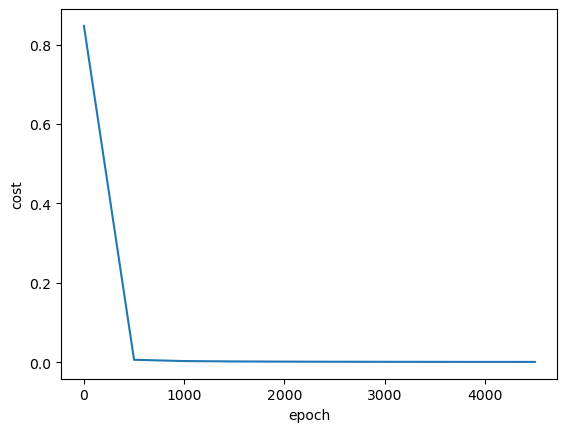

In [ ]:
import matplotlib.pyplot as plt

# toy dataset: logical OR-ish
X = np.array([[0., 0., 1., 1.], [0., 1., 0., 1.]])   # (2,4)
Y = np.array([[0, 1, 1, 1]])                     # (1,4)

layer_dims = [2, 4, 1]  # input 2 -> 4 hidden -> 1 output
params = initialize_parameters_deep(layer_dims, init="he")
lr = 0.5
costs = []

for epoch in range(5000):
    AL, caches = L_model_forward(
        X, params, hidden_activation="relu", output_activation="sigmoid")
    cost = compute_cost_binary(AL, Y)
    grads = L_model_backward(
        AL, Y, caches, output_activation="sigmoid", hidden_activation="relu")
    params = update_parameters(params, grads, learning_rate=lr)
    if epoch % 500 == 0:
        costs.append(cost)
        print("epoch", epoch, "cost", cost)

# final predict
AL, _ = L_model_forward(
    X, params, hidden_activation="relu", output_activation="sigmoid")
preds = (AL > 0.5).astype(int)
print("preds:", preds)
plt.plot(np.arange(0, len(costs))*500, costs)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()


11. Diagnostics & tips code snippets


In [ ]:
# 1) percent of ReLU neurons dead in a layer (given Z)
def percent_dead_relu(Z):
    return np.mean(Z <= 0) * 100

# 2) gradient norms


def grad_norms(grads):
    norms = {}
    for k, v in grads.items():
        norms[k] = np.linalg.norm(v)
    return norms

# Use these during training:
# print(percent_dead_relu(caches[0][1]))  # caches layer: (linear_cache, activation_cache) -> activation_cache is Z
# print(grad_norms(grads))


Ghi chú kết thúc (ngắn, thẳng)

Đây là bản mẫu tối giản — mục tiêu để bạn hiểu từng bước và chạy nhanh.

Khi scale lên (nhiều layer, nhiều dữ liệu), thêm: batchnorm, dropout, optimizer (Adam), gradient clipping, numeric stability kỹ hơn.

Nếu bạn muốn: mình chỉnh code trên để phù hợp đúng với notebook của bạn (ví dụ shapes hoặc tên hàm tests mong đợi) — paste đoạn #GRADED FUNCTION bạn đã viết hoặc gửi lỗi test, mình sửa trực tiếp.
